# Analyzing NYC High School Data
New York City has a large immigrant population and as such is quite diverse.

In this project we will be combining many datasets relating to students in New York City public school for grades (Class Years) 09-12.

The data we will be using is

- [SAT scores by school](https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/School-Attendance-and-Enrollment-Statistics-by-Dis/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8) - Surveys of parents, teachers, and students at each school


### Read in the data

In [1]:
import pandas as pd
import numpy
import re
import matplotlib
%matplotlib inline

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
#We will create a dictionary to hold each of these files#
#The key will be the data_file name without the .csv part#
data = {}

for file in data_files:
    d = pd.read_csv("schools/{0}".format(file))
    data[file.replace(".csv", "")] = d

In [2]:
#Set options in pandas to display all our columns & rows
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data['hs_directory'].head()

,dbn,school_name,boro,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,bus,subway,primary_address_line_1,city,state_code,zip,website,total_students,campus_name,school_type,overview_paragraph,program_highlights,language_classes,advancedplacement_courses,online_ap_courses,online_language_courses,extracurricular_activities,psal_sports_boys,psal_sports_girls,psal_sports_coed,school_sports,partner_cbo,partner_hospital,partner_highered,partner_cultural,partner_nonprofit,partner_corporate,partner_financial,partner_other,addtl_info1,addtl_info2,start_time,end_time,se_services,ell_programs,school_accessibility_description,number_programs,priority01,priority02,priority03,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1
0,17K548,Brooklyn School for Music & Theatre,Brooklyn,K440,718-230-6250,718-230-6262,9,12,NaN,NaN,"B41, B43, B44-SBS, B45, B48, B49, B69","2, 3, 4, 5, F, S to Botanic Garden ; B, Q to P...",883 Classon Avenue,Brooklyn,NY,11225,Bkmusicntheatre.com,399.0,Prospect Heights Educational Campus,NaN,Brooklyn School for Music & Theatre (BSMT) use...,We offer highly competitive positions in our D...,Spanish,"English Language and Composition, United State...",NaN,NaN,"Variety of clubs: Chess, The Step Team, Fashio...","Baseball, Basketball & JV Basketball, Cross Co...","Basketball, Cross Country, Indoor Track, Outdo...",NaN,NaN,F.Y.R.EZONE (Finding Your Rhythm thru Educatio...,NaN,NaN,"In 2002, Roundabout Theatre was selected by Ne...",One To World‘s Global Classroom connects New Y...,NaN,NaN,NaN,NaN,NaN,8:10 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Brooklyn students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"883 Classon Avenue\nBrooklyn, NY 11225\n(40.67..."
1,09X543,High School for Violin and Dance,Bronx,X400,718-842-0687,718-589-9849,9,12,NaN,NaN,"Bx13, Bx15, Bx17, Bx21, Bx35, Bx4, Bx41, Bx4A,...","2, 5 to Intervale Ave",1110 Boston Road,Bronx,NY,10456,www.hsvd.org,378.0,Morris Educational Campus,NaN,The High School for Violin and Dance (HSVD) is...,Freshmen take both violin and dance; College N...,Spanish,NaN,NaN,NaN,Advancement via Individual Determination (AVID...,"Baseball, Basketball & JV Basketball, Volleyball","Basketball, Softball, Volleyball",NaN,Morris Educational Campus Basketball and Volle...,McGraw Hill - Big Brother Big Sister,NaN,"Hostos Community College, Monroe College, Teac...",Bronx Arts Ensemble,buildOn,Print International,NaN,Bronx Cares,Our students are required to take four years o...,"Student Summer Orientation, Summer Internship ...",8:00 AM,3:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to Bronx students or residents who at...,Then to New York City residents who attend an ...,Then to Bronx students or residents,Then to New York City residents,NaN,NaN,NaN,NaN,NaN,NaN,"1110 Boston Road\nBronx, NY 10456\n(40.8276026..."
2,09X327,Comprehensive Model School Project M.S. 327,Bronx,X240,718-294-8111,718-294-8109,6,12,NaN,NaN,"Bx1, Bx11, Bx13, Bx18, Bx2, Bx3, Bx32, Bx35, Bx36","4 to Mt Eden Ave ; B, D to 170th St",1501 Jerome Avenue,Bronx,NY,10452,http://schools.nyc.gov/schoolportals/09/X327,543.0,DOE New Settlement Community Campus,NaN,At the Comprehensive Model School Project (CMS...,"After-school and Saturday Tutoring, Advisory, ...",Spanish,"Biology, Chemistry, United States History",NaN,NaN,"Choir, Gaming, Girls Club, Newspaper, Spanish,...",NaN,NaN,NaN,"As we expand, we plan to offer PSAL sports.",New Settlement Community Center,Montefiore Hospital,NaN,NaN,NaN,NaN,NaN,NaN,Dress Code Required: white or baby blue button...,NaN,8:00 AM,4:00 PM,This school will provide students with disabil...,ESL,Functionally Accessible,1,Priority to continuing 8th graders,Then to Bronx students or residents who attend...,Then to New York City residents who attend an ...,Then to Bronx stud

# Read in the surveys

In [4]:
#survey are 'tab delimited' and windows-1252 encoded so we need to set this information in the read_csv method#
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)



# Add DBN columns
Each school in New York has a unique identifier, the district borough number (DBN).

For example '09X543' is the High School for Violin and Dance.
Before we join the databases we will ensure the DBN's exist and are in the same format in each database.

We will also select the correct fields we want to import. Here is a [dictionary](https://s3.amazonaws.com/dq-content/xj5ud4r.png) of the columns available in the survey.


In [5]:
#Survey dbn exists we will just create the new column of DBN using this.#
survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", #School ID#
    "rr_s", #Student Response Rate#
    "rr_t", #Teacher Response Rate
    "rr_p", #Parent Response Rate#
    "N_s", #Student Response Number#
    "N_t", #Teacher Response Number#
    "N_p", #Parent Response Number#
    "saf_p_11", #Parent Safety and Respect Survey Response#
    "com_p_11", #Parent Communication Survey Response#
    "eng_p_11", #Parent Engagement Survey Response# 
    "aca_p_11", #Parent Academic Expectation Survey Response#
    "saf_t_11", #Teacher Safety and Respect Survey Response#
    "com_t_11", #Teacher Communication Survey Response#
    "eng_t_11", #Teacher Engagement Survey Response#
    "aca_t_11", #Teacher Academic Expectation Survey Response#
    "saf_s_11", #Student Safety and Respect Survey Response#
    "com_s_11", #Student Communication Survey Response#
    "eng_s_11", #Student Engagement Survey Response#
    "aca_s_11", #Student Academic Expectation Survey Response#
    "saf_tot_11", #Safety and Respect Survey Total Score#
    "com_tot_11", #Communication Survey Total Score#
    "eng_tot_11", #Engagement Survey Total Score#
    "aca_tot_11", #Academic Expectation Survey Total Score#
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [6]:
print(data["class_size"][["CSD","SCHOOL CODE"]].sample(10))

       CSD SCHOOL CODE
26963   31        R450
7618     9        X239
1635     2        M414
913      2        M150
18777   21        K620
21264   25        Q165
2502     2        M655
24137   28        Q328
27355   32        K376
3758     4        M409


To get a uniform format for DBN we will need to combine these two columns and ensure any single digit at the start is preceded by a zero.

In [7]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]


def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
print(data["class_size"]["DBN"].sample(10))

22095    26Q173
27033    31R460
3654     04M224
15694    17K600
26887    31R440
20471    24Q093
27071    31R470
4693     06M152
25806    30Q450
9257     10X340
Name: DBN, dtype: object


# Convert columns to numeric

Lets look at the sat_results database.

In [8]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 6 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    478 non-null object
SAT Math Avg. Score                478 non-null object
SAT Writing Avg. Score             478 non-null object
dtypes: object(6)
memory usage: 22.5+ KB


All values here are set as non-null objects. These are strings. However for pandas to correctly perform mathematical operations we need to set the columns that represent numbers as floats.

In [9]:
cols = ['SAT Math Avg. Score',
        'SAT Critical Reading Avg. Score',
        'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

In [10]:
data["sat_results"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 7 columns):
DBN                                478 non-null object
SCHOOL NAME                        478 non-null object
Num of SAT Test Takers             478 non-null object
SAT Critical Reading Avg. Score    421 non-null float64
SAT Math Avg. Score                421 non-null float64
SAT Writing Avg. Score             421 non-null float64
sat_score                          421 non-null float64
dtypes: float64(4), object(3)
memory usage: 26.2+ KB


Next step is to isolate the latitude and longitude coordinates of the schools.

Manhattens coordinates for instance are 40.7831° N, 73.9712° W. (Latitude being the North/South coordinate)

Lets have a look at the location data.

In [11]:
data["hs_directory"]["Location 1"].sample(5).tolist()

['122 Amsterdam Avenue\nNew York, NY 10023\n(40.77429641100048, -73.98482270099964)',
 '71-77 Clinton Avenue\nBrooklyn, NY 11205\n(40.69566241300049, -73.96928607699965)',
 '350 Grand Street\nNew York, NY 10002\n(40.71686722400045, -73.98953194299963)',
 '439 West 49Th Street\nNew York, NY 10019\n(40.763361732000476, -73.99050909099964)',
 '1021 Jennings Street\nBronx, NY 10460\n(40.83080715400047, -73.88602131599964)']

Latitude we see here is displayed first and we can create regular expressions (REGEX) to capture the bracketed information and use this to form latitude and longitude columns.

In [12]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    #/( Denotes match an open bracket.#
    #.+ Denotes any character(except line) breaks and find any length string#
    #,.+ Find the comma and repeat the any character any length operation#
    #/) Denotes close the match with a closed bracket#
    
    #next split the string on the comma and replace the bracket#
    lat = coords[0].split(",")[0].replace("(", "")
    
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [13]:
data["hs_directory"][["DBN","lat","lon"]].sample(5)

,DBN,lat,lon
41,17K382,40.649440,-73.958431
118,24Q585,40.729538,-73.887391
339,20K490,40.627913,-74.039952
102,09X564,40.840373,-73.910838
3,02M280,40.710679,-74.000807


# Condense datasets
In our progress to combine these datasets we come across an issue. There are multiple instances of a DBN in the class_size database.

In [14]:
print(data["class_size"][["SCHOOL NAME","DBN","GRADE ","PROGRAM TYPE"]].head(10))
print()
print("The unique values in the Grade columns are:")
print(data["class_size"]["GRADE "].value_counts())
print()
print("The unique values in the Programme Type columns are:")
print(data["class_size"]["PROGRAM TYPE"].value_counts())

                 SCHOOL NAME     DBN GRADE  PROGRAM TYPE
0  P.S. 015 Roberto Clemente  01M015     0K       GEN ED
1  P.S. 015 Roberto Clemente  01M015     0K          CTT
2  P.S. 015 Roberto Clemente  01M015     01       GEN ED
3  P.S. 015 Roberto Clemente  01M015     01          CTT
4  P.S. 015 Roberto Clemente  01M015     02       GEN ED
5  P.S. 015 Roberto Clemente  01M015     02          CTT
6  P.S. 015 Roberto Clemente  01M015     03       GEN ED
7  P.S. 015 Roberto Clemente  01M015     03          CTT
8  P.S. 015 Roberto Clemente  01M015     04       GEN ED
9  P.S. 015 Roberto Clemente  01M015     05       GEN ED

The unique values in the Grade columns are:
09-12      10644
MS Core     4762
0K-09       1384
0K          1237
01          1185
02          1167
03          1143
04          1140
05          1086
06           846
07           778
08           735
09            20
Name: GRADE , dtype: int64

The unique values in the Programme Type columns are:
GEN ED     14545
CTT      

As we can see the issue stems from having multiple Grade (School Years) and Programme Types in the database. 

We are interested only in Grade 09-12 for this project and will remove all other entries before merging databases later.

For this project we will keep only the GEN ED (general education) category in the Programme Type as it best represents our class size in general and will also allow the most rows to be retained.

We also have one more issue:

In [15]:
data["class_size"].loc[231:234][["SCHOOL CODE", "GRADE ", "CORE SUBJECT (MS CORE and 9-12 ONLY)", "CORE COURSE (MS CORE and 9-12 ONLY)"]]

,SCHOOL CODE,GRADE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY)
231,M292,09-12,MATH,Geometry
232,M292,09-12,MATH,Other Math
233,M292,09-12,SCIENCE,Earth Science
234,M292,09-12,SCIENCE,Living Environment


In [16]:
print(data["class_size"]["CORE SUBJECT (MS CORE and 9-12 ONLY)"].value_counts())
print(data["class_size"]["CORE COURSE (MS CORE and 9-12 ONLY)"].value_counts())

-                 10721
ENGLISH            4433
SCIENCE            3923
SOCIAL STUDIES     3606
MATH               3444
Name: CORE SUBJECT (MS CORE and 9-12 ONLY), dtype: int64
-                              10721
MS English Core                 1188
Integrated Algebra              1046
MS Math Core                    1003
MS Science Core                  990
MS Social Studies Core           987
Living Environment               941
Global History & Geography       889
US History & Government          741
English 9                        733
English 10                       690
Other Science                    682
English 11                       662
Earth Science                    659
Other English                    603
Geometry                         597
English 12                       557
Participation in Government      409
Other Social Studies             398
Chemistry                        385
Trigonometry                     338
Other Math                       289
Physics  

As we can see sometimes the rows are subsets and show individual class size per course type. 

We can solve this issue by working out the mean using the groupby function on the DBN column.

Another issue lies with the 'demographics' and 'graduation' database:

In [17]:
print(data["demographics"][["DBN","schoolyear"]].head(10))
print()
print("The unique value counts for School Year column are:")
print(data["demographics"]["schoolyear"].value_counts())

      DBN  schoolyear
0  01M015    20052006
1  01M015    20062007
2  01M015    20072008
3  01M015    20082009
4  01M015    20092010
5  01M015    20102011
6  01M015    20112012
7  01M019    20052006
8  01M019    20062007
9  01M019    20072008

The unique value counts for School Year column are:
20112012    1509
20102011    1498
20092010    1475
20082009    1441
20072008    1410
20062007    1386
20052006    1356
Name: schoolyear, dtype: int64


In [18]:
print(data["graduation"][["DBN","Cohort"]].sample(10))
print()
print("The unique value counts for Cohort column are:")
print(data["graduation"]["Cohort"].value_counts())
print()
print(data["graduation"][["DBN","Demographic"]].sample(10))
print()
print("The unique value counts for Demographic column are:")
print(data["graduation"]["Demographic"].value_counts())

          DBN    Cohort
7241   02M475      2003
24113  14K558      2006
3579   12X278  2006 Aug
23389  07X527  2006 Aug
13297  23K645      2003
15635  23K493      2006
10890  14K322      2004
16249  02M407      2002
12260  02M570      2005
577    04M695      2004

The unique value counts for Cohort column are:
2006 Aug    4131
2006        4130
2005        3963
2004        3708
2003        3432
2002        3095
2001        2637
Name: Cohort, dtype: int64

          DBN                  Demographic
18534  01M515                        White
2024   23K697                 Total Cohort
495    03M490                 Total Cohort
10412  09X505   General Education Students
6309   18K635  English Proficient Students
2857   03M299    English Language Learners
4010   19K660    English Language Learners
10772  12X684   General Education Students
24489  20K490                         Male
15665  24Q264                        Black

The unique value counts for Demographic column are:
Total Cohort   

Again we have multiple subsets for each DBN.
Lets use:
- schoolyear = 20112012
- Cohort = 2006
- Demographic = Total Cohort
To give the most recent data (from this dataset), the most entries and the most relevant data

In [19]:
class_size = data["class_size"]
#Filter to include only Grade 09-12 and GEN ED Program Types#
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

#Find average class size to eliminate subset issue#
class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
#Filter to include only 2011-2012 year group#
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]
#Filter to select desired Cohort and Demographic#
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric
The only remaining thing to do before combining datasets is to convert the Advanced Placement (AP) test scores from strings to numeric values. 
- High school students take the AP exams before applying to college. There are several AP exams, each corresponding to a school subject. High school students who earn high scores may receive college credit.
- AP exams have a 1 to 5 scale; 3 or higher is a passing score.


In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
When merging data it is important to consider how the datasets should be combined. We will use the DBN column to tell pandas were to combine rows with the same DBN.

Consider an example code:

database1.merge(database2, on="column-name", how=left)
- Left merge will keep all rows on the 'left' (database1) and any DBN values were unique to the right (database2) would not be included.
- Outer merge will keep all rows. And create lots of empty spaces if there are many unique DBN values for the databases.
- Inner merge will only keep DBN values that match in database1 and database2. Any unique rows to either database would be lost.

The aim of this project is to see if there are demographic factors that correlate with SAT score.

Therefore we'll want to preserve as many rows as possible from sat_results while minimizing null values.

Sat_results will start as our left database. Any database will be sequentially added to this. 

Left merge will be used when the right database has many missing DBN values. Inner merge will be used where most DBN values match.

We will fill any empty regions with the mean of the columns and where a column cannot compute an average (ie it is mostly Nan) we will fill this with zero.

In [21]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping
The school district is the first two characters of the DBN. We will create a new column that captures this information

In [22]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations
The pandas method 'corr' can show how closely correlated a select column is with all the other columns. As we are looking at influences of sat_score we can use this column to show the strongest and weakest correlation.

In [23]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations.sort_values(ascending=False))

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

We can see some things like the Average Scores for the SATS are strongly correlated, this is hardly suprising as the Sat_Score was created by the average of these.
- 'white_per' & 'asian_per' (White and Asian percentages) show positive correlation with SAT score.
- 'sped_percent' & 'frl_percent' (Special Education and Foreign Language percentage) show negative correlation with SAT score. 

We will explore this and more later.

# Plotting survey correlations

## Plotting a bar chart of correlations between Sat Score and a series of Surveys.

In [24]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [25]:
import matplotlib.pyplot as plt

In [26]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


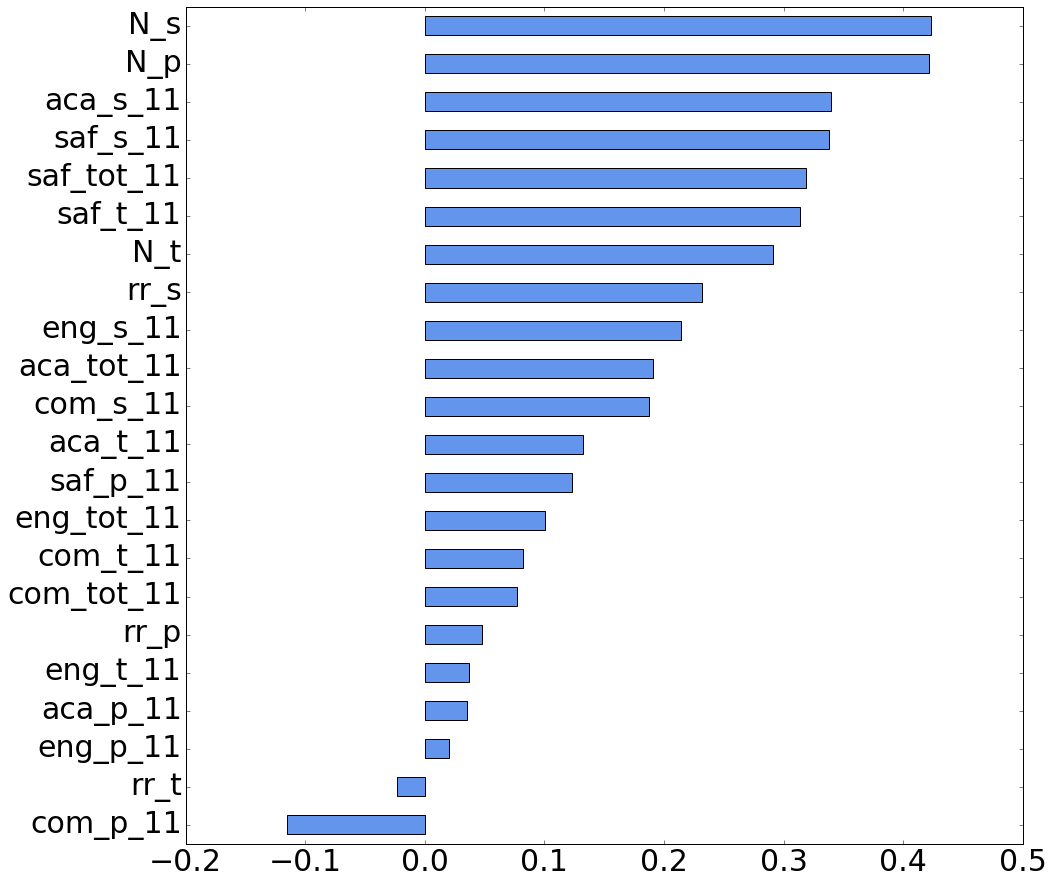

In [27]:
correlations = combined.corr()["sat_score"]
plt = correlations[survey_fields].sort_values().plot.barh(figsize=(15,15), color="cornflowerblue", fontsize=30)

Things that show positive correlation with the SAT scores:
- Students, Parents or Teachers response number
- Students or Teachers 'Safety and Respect' response
- Student 'Academic Expectation' Response

Things that show weak positive correlation with SAT scores:
- Students, Parents or Teachers 'Engagement' response
- Parents 'Safety and Respect' response
- Students, Parents or Teachers 'Communication' response
- Parents or Teacher 'Academic Expectation' Response

Things that show weak negative correlation:
- Parent 'Communication Survey' response

This shows that in general a good SAT school is more likely to have a higher response number (perhaps a larger school), and is percieved by all to have high Safety and Respect, and to a lesser extent 'Academic Expectation' or 'Engagement'. 

Communication is both negative and positive between respondents but is overall weakly positive correlating.

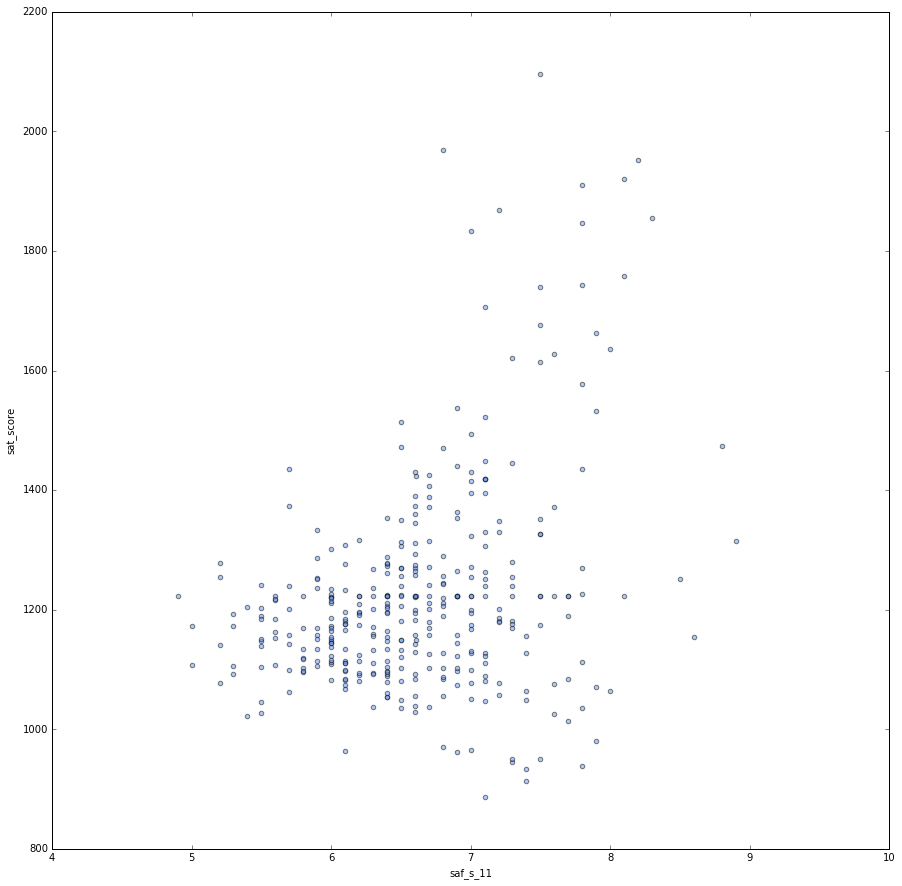

In [75]:
#Plotting the Safety and Respect column vs the SAT score.
combined.plot.scatter("saf_s_11","sat_score", alpha = 0.5, figsize=(15,15), color="cornflowerblue")

This graph confirms that safety and respect score has some positive correlation on SAT score

## Plotting Safety Perception in the New York City Map

In [29]:
school_dist = combined.groupby("school_dist").agg(numpy.mean)
school_dist.reset_index(inplace=True)

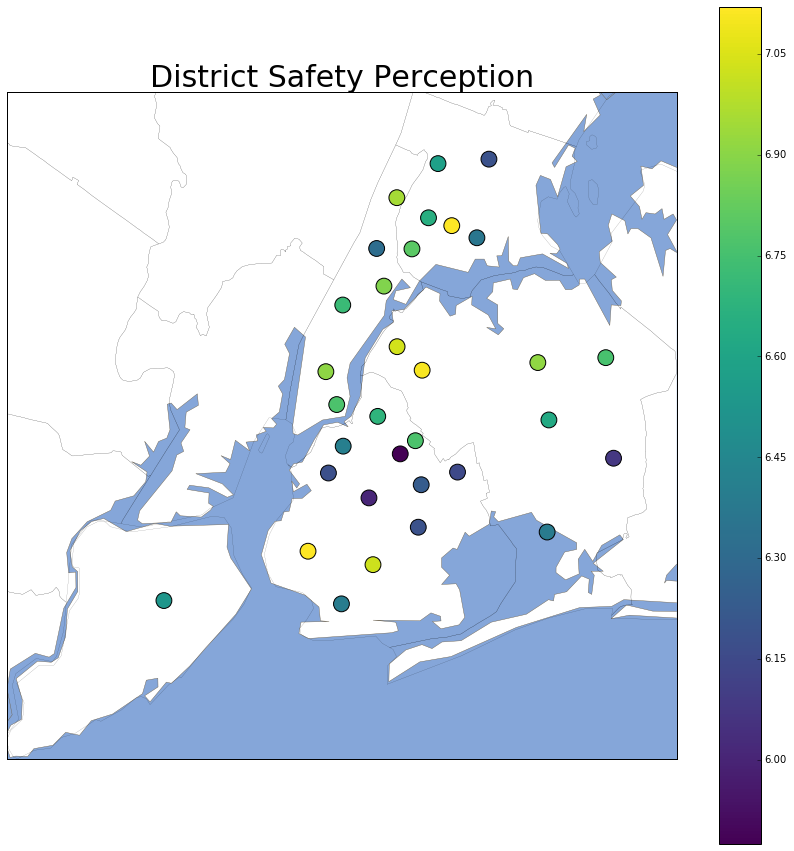

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
#create the map centered on New York city#
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(15, 15))
m = Basemap (projection = 'merc', llcrnrlat = 40.496044, urcrnrlat = 40.915256, llcrnrlon = -74.255735, urcrnrlon = -73.700272, resolution = 'h')
#Set the longitudes and Latitudes to lists#
longitudes = school_dist["lon"].tolist()
latitudes = school_dist["lat"].tolist()
#Map settings#
m.drawmapboundary(fill_color = '#85A6D9') 
m.drawcoastlines(color = '#6D5F47', linewidth =.4)
m.drawrivers(color = '#6D5F47', linewidth =.4)
m.fillcontinents(color="white")
m.drawcounties(color="black",zorder=999) #set county outlines to black and bring to front#

m.scatter(longitudes, latitudes, s=250, zorder=2, latlon=True, c=school_dist["saf_s_11"], cmap="viridis") #cmap dictates the colour range#
plt.title("District Safety Perception",fontsize=30)
plt.colorbar()
plt.show()

The above displays the safety perception around the New York school area. Safety perception seems to be lowest around the central parts of brooklyn with the northern parts being marginally safer.

Even so the range of safety scores is quite small.

## Plotting SAT scores in the New York City Map

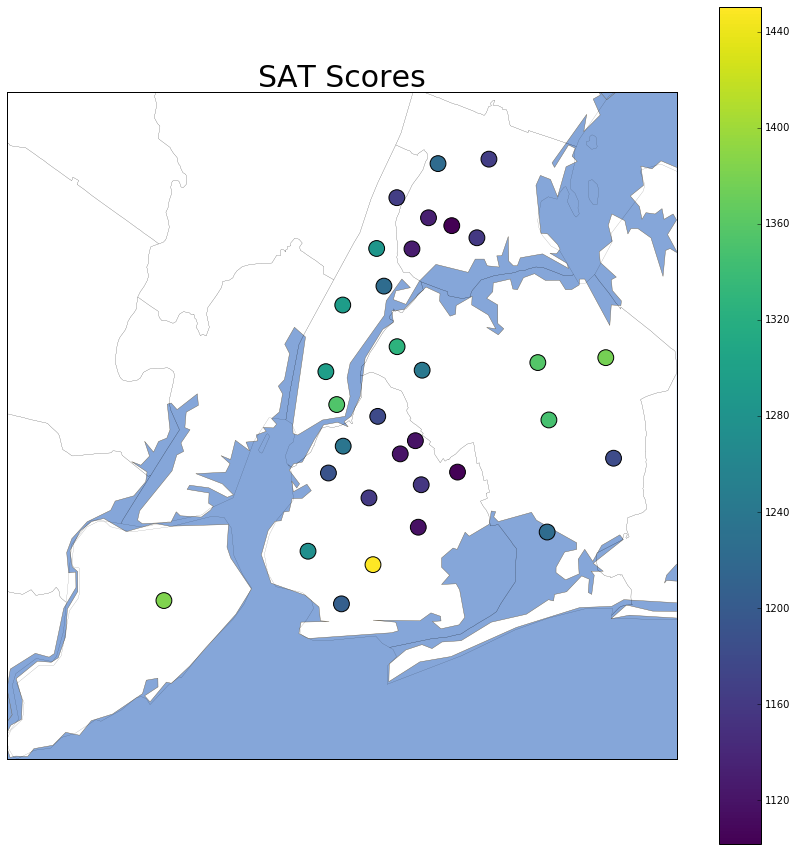

In [31]:
#create the map centered on New York city#
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(15, 15))
m = Basemap (projection = 'merc', llcrnrlat = 40.496044, urcrnrlat = 40.915256, llcrnrlon = -74.255735, urcrnrlon = -73.700272, resolution = 'h')
#Set the longitudes and Latitudes to lists#
longitudes = school_dist["lon"].tolist()
latitudes = school_dist["lat"].tolist()
#Map settings#
m.drawmapboundary(fill_color = '#85A6D9') 
m.drawcoastlines(color = '#6D5F47', linewidth =.4)
m.drawrivers(color = '#6D5F47', linewidth =.4)
m.fillcontinents(color="white")
m.drawcounties(color="black",zorder=999) #set county outlines to black and bring to front#

m.scatter(longitudes, latitudes, s=250, zorder=2, latlon=True, c=school_dist["sat_score"], cmap="viridis") #cmap dictates the colour range#
plt.title("SAT Scores",fontsize=30)
plt.colorbar()
plt.show()

There are some mixed trends here.
([Here is a map for clarity](https://nycmap360.com/website/var/tmp/image-thumbnails/0/979/thumb__map/nyc-borough-map.png))

- In Manhatten, the further south the higher the SAT scores are 
- The same is generally true for Brooklyn.
- Staten Island has only one district but one with quite high SAT scores.
- Queens has Generally average SAT result schools
- The Bronx has on average the worst performing SAT results.
- Brookly has one district with exceptionally high SAT scores.


In [32]:
school_dist[["school_dist", "sat_score"]].sort_values(by="sat_score",ascending=False).head()

,school_dist,sat_score
21,22,1450.5
30,31,1382.5
25,26,1377.6
24,25,1357.0
0,01,1354.5


Above is the top 5 districts.
A school district map can be found [here](https://video.eschoolsolutions.com/udocs/DistrictMap.pdf).

## Race vs SAT scores.

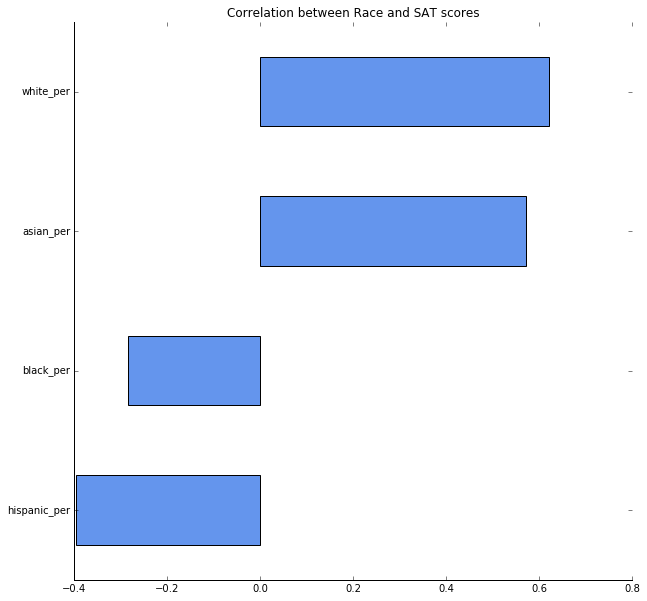

In [52]:
races = ["white_per", "asian_per", "black_per", "hispanic_per"]
ax = correlations[races].sort_values()
ax = ax.plot(kind = "barh", figsize=(10,10), color="cornflowerblue", title ="Correlation between Race and SAT scores")
ax.spines['right'].set_visible(False)
ax.spines["top"].set_visible(False)

The correlation shows:
- White and asian students perform better on average than those of black or hispanic backgrounds.
- The negative correlation is higher for hispanic than for black students.

There is a higher value of SAT scores for white students than asian students, this is unexpected and often the reverse is true.

## Working out % Hispanic vs SAT

Lets first work out whats would be high and low scores for the SAT scores.

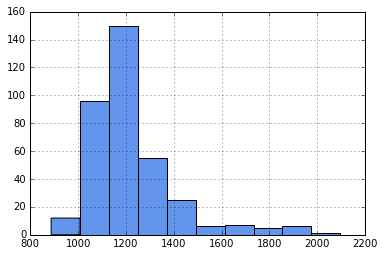

In [56]:
combined["sat_score"].hist(color="cornflowerblue")

Lets say a low SAT score is <=1000 and high score is >=1800. Then lets Filter for high and low SATs.

     sat_score  hispanic_per
253      887.0          99.8
225      913.0          27.9
141      934.0          99.8
179      939.0          84.6
91       945.0          71.8
286      951.0         100.0
125      951.0          99.4
139      962.0          84.7
237      963.0           4.5
126      965.0          72.2
176      970.0          99.8
188      981.0          28.6
187     1833.0           7.9
79      1847.0          21.2
5       1856.0          18.2
327     1868.0           7.9
302     1910.0          12.9
155     1920.0          18.0
356     1953.0           5.3
151     1969.0           7.2
37      2096.0           2.4


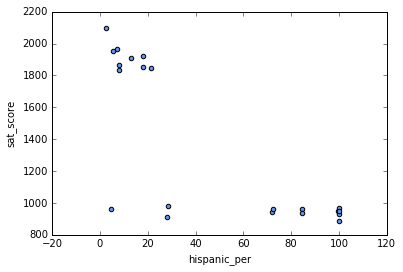

In [74]:
high_low_sats_filter = (combined["sat_score"] <= 1000) | (combined["sat_score"] > 1800 )
high_low_sats_hisp = combined[high_low_sats_filter][["sat_score","hispanic_per"]]
print(high_low_sats_hisp.sort_values(by=["sat_score"]))
high_low_sats_hisp.plot( x = "hispanic_per", y= "sat_score", kind= "scatter", color="cornflowerblue")

The graph speaks volumes. Schools with disproportionately high hispanic percentages are worse performing than those with low hispanic percentages (with a few exceptions).
Can these exceptions be explained?

In [61]:
#work out the schools were hispanic percentage is low and sat score is low#
sat_low_hisp_low_filter = (combined["sat_score"] <= 1000) & (combined["hispanic_per"] <=40 )
sat_low_hisp_low = combined[sat_low_hisp_low_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_low_hisp_low)

                                       SCHOOL NAME  sat_score  white_per  asian_per  hispanic_per  black_per
188             BROOKLYN INTERNATIONAL HIGH SCHOOL      981.0        8.7       42.5          28.6       20.2
225  INTERNATIONAL HIGH SCHOOL AT PROSPECT HEIGHTS      913.0       14.2       28.4          27.9       29.2
237                     IT TAKES A VILLAGE ACADEMY      963.0        0.5        1.8           4.5       92.9


Two of these are international schools with high percentage of english learners so would be expected these would perform lower on the SATs.
The latter, "It takes a village academy", has a very high black percentage which in general have lower SAT scores and could be a factor.

## Investigating very high hispanic percentage schools
Now lets look at those high percentage hispanic schools.

In [62]:
hisp_high_filter = (combined["hispanic_per"] >= 95 )
hisp_high = combined[hisp_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(hisp_high)

                                           SCHOOL NAME  sat_score  white_per  asian_per  hispanic_per  black_per
44                       MANHATTAN BRIDGES HIGH SCHOOL     1058.0        0.0        0.2          99.8        0.0
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL     1174.0        0.3        0.0          96.7        2.3
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...     1014.0        0.0        0.0          99.8        0.0
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY      951.0        0.0        0.0          99.4        0.6
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS      934.0        0.0        0.2          99.8        0.0
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE      970.0        0.0        0.0          99.8        0.0
253                          MULTICULTURAL HIGH SCHOOL      887.0        0.0        0.0          99.8        0.2
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL      951.0        0.0        0.0         

All of these schools cater for international students (from Dominican Republic and other spanish speaking countries).
This naturally would be more difficult and we could expect lower SAT scores.

Next lets look at the low hispanic percentage but high sat scored schools.

In [63]:
sat_high_hisp_low_filter = (combined["sat_score"] >= 1800) & (combined["hispanic_per"] <=10 )
sat_high_hisp_low = combined[sat_high_hisp_low_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_high_hisp_low)

                                           SCHOOL NAME  sat_score  white_per  asian_per  hispanic_per  black_per
37                              STUYVESANT HIGH SCHOOL     2096.0       23.7       72.1           2.4        1.2
151                       BRONX HIGH SCHOOL OF SCIENCE     1969.0       25.4       63.5           7.2        3.5
187                     BROOKLYN TECHNICAL HIGH SCHOOL     1833.0       21.3       60.3           7.9       10.2
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...     1868.0        6.7       74.4           7.9       10.5
356                STATEN ISLAND TECHNICAL HIGH SCHOOL     1953.0       61.3       31.8           5.3        1.1


These schools are all part of the NYC's 'specialised high schools' for students that 'excel academically or artistically'.

## Comparing Gender to SAT scores

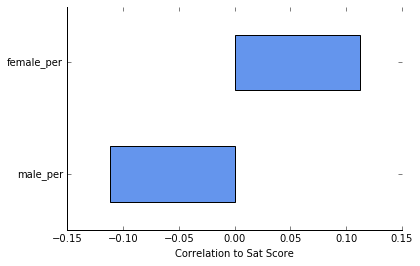

In [66]:
gender = ["male_per", "female_per"]
ax2 = correlations[gender].sort_values()
ax2 = ax2.plot(kind = "barh", color="cornflowerblue")
ax2.set_xlabel("Correlation to Sat Score")
ax2.spines['right'].set_visible(False)
ax2.spines["top"].set_visible(False)

plt.show()

- Female percentage is weakly positively correlated with higher SAT scores. 
- Male percentage is weakly negatively correlated with higher SAT scores.

Hence in general, schools with more female than male students perform better in the SATs.
But this correaltion is only ~0.1 which is a very weak correlation.

## Comparing Female Percentage with SAT score

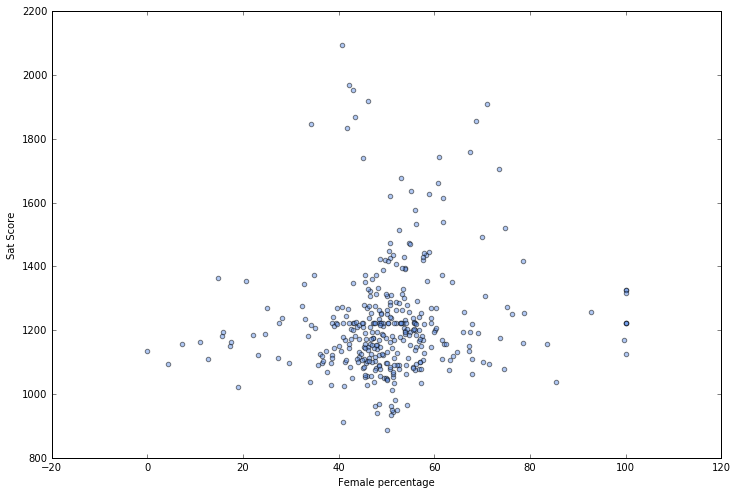

In [78]:
ax = combined.plot.scatter(x="female_per", y="sat_score", figsize=(12,8), color="cornflowerblue", alpha = 0.5)
ax.set_xlabel("Female percentage")
ax.set_ylabel("Sat Score")
plt.show()

The graph is nebulous with no specific trend. High and low female percentages seem to have average performance in the SATs. SAT scores above 1500 have between 35 and 80% female students.

Now lets look at the highest SAT performing schools with above 60% female students.

In [68]:
sat_high_female_high_filter = (combined["sat_score"] >= 1700) & (combined["female_per"] >=60 )
sat_high_female_high = combined[sat_high_female_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(sat_high_female_high)


                                           SCHOOL NAME  sat_score  white_per  asian_per  hispanic_per  black_per
5                       BARD HIGH SCHOOL EARLY COLLEGE     1856.0       49.8       15.1          18.2       15.1
26                       ELEANOR ROOSEVELT HIGH SCHOOL     1758.0       63.7       17.2          11.6        5.5
60                                  BEACON HIGH SCHOOL     1744.0       49.8        8.9          22.8       14.6
61   FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...     1707.0       49.2       19.6          16.6       12.9
302                        TOWNSEND HARRIS HIGH SCHOOL     1910.0       24.6       55.5          12.9        5.9


Fiorello H Laguardia is on the list of exceptional schools for artistic students.
The others similarly seem to be arts schools.

## Exploring correlation between Advanced Placement (AP) exams and SAT scores

In [71]:
combined["ap_per"] = (combined["AP Test Takers "] / combined["total_enrollment"]) #Creat a column showing the percentage of AP test takers as a decimal#
print(combined[["AP Test Takers ", "total_enrollment", "ap_per"]].head())

   AP Test Takers   total_enrollment    ap_per
0       129.028846               422  0.305756
1        39.000000               394  0.098985
2        19.000000               598  0.031773
3       129.028846               367  0.351577
4       255.000000              1613  0.158091


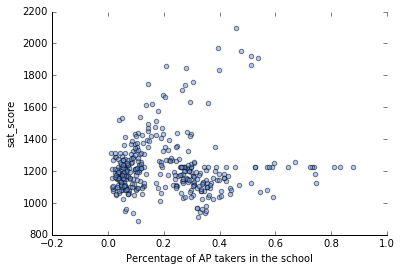

In [79]:
ax3 = combined.plot.scatter(x="ap_per", y="sat_score", color="cornflowerblue", alpha = 0.5)
ax3.set_xlabel("Percentage of AP takers in the school")
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
plt.show()

In general there is no trend.

It almost looks like there are two trends, one showing a positive linear relationship and the other showing no relationship at all. 

The highest of percentage AP takers seem to show no increase in SAT scores at all. We should investigate why.

In [72]:
ap_high_filter = (combined["ap_per"] >= 0.7)
ap_high = combined[ap_high_filter][["SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per"]]
print(ap_high)

                                           SCHOOL NAME    sat_score  white_per  asian_per  hispanic_per  black_per
6    47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...  1182.000000        6.3        1.7          59.2       32.2
31               MANHATTAN ACADEMY FOR ARTS & LANGUAGE  1223.438806        1.1        6.3          84.6        8.0
33           INTERNATIONAL HIGH SCHOOL AT UNION SQUARE  1223.438806        3.4       40.3          43.2       12.5
83           HIGH SCHOOL FOR EXCELLENCE AND INNOVATION  1223.438806        0.0        0.0          72.5       25.8
111                          BRONX BRIDGES HIGH SCHOOL  1223.438806        2.6        5.2          83.2        8.4
208                            FRANCES PERKINS ACADEMY  1122.000000        4.0        0.0          31.2       64.7
222             THE BROOKLYN ACADEMY OF GLOBAL FINANCE  1223.438806        2.5        1.9          20.8       74.2
335                            CAMBRIA HEIGHTS ACADEMY  1223.438806        2.0  

These schools are specialist schools designed for international students, students with disabilities or students who require additional years to complete school.

## Exploring relationship between class size and SAT scores

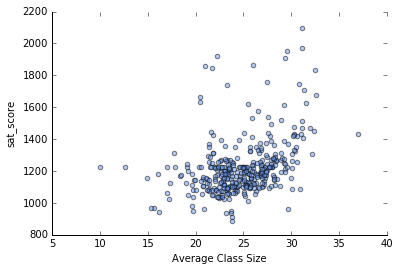

In [80]:
ax4 = combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score", color="cornflowerblue", alpha = 0.5)
ax4.set_xlabel("Average Class Size")
ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
plt.show()

Schools with small class sizes often report that this is good for the development of the student. 
The graph shows this claim is not supported. 
Lets review class sizes that are below 15 and above 35 to see what we can learn

In [81]:
class_size_high_and_low_filter = (combined["AVERAGE CLASS SIZE"] <= 15) | (combined["AVERAGE CLASS SIZE"] >= 35)
class_size_high_and_low  = combined[class_size_high_and_low_filter ][["AVERAGE CLASS SIZE","SCHOOL NAME","sat_score","white_per","asian_per","hispanic_per", "black_per","female_per","male_per"]]
print(class_size_high_and_low )

     AVERAGE CLASS SIZE                                     SCHOOL NAME    sat_score  white_per  asian_per  hispanic_per  black_per  female_per  male_per
8             14.900000                            ESSEX STREET ACADEMY  1156.000000        7.6        4.1          60.6       27.7        46.6      53.4
17            37.023077                                     NYC ISCHOOL  1435.000000       24.0       11.5          43.0       20.6        51.3      48.7
56            10.000000     THE URBAN ASSEMBLY SCHOOL FOR GREEN CAREERS  1223.438806        1.8        1.8          76.0       19.8        43.1      56.9
264           12.575000  THE URBAN ASSEMBLY SCHOOL FOR CRIMINAL JUSTICE  1223.438806        9.1       35.0          21.9       33.7       100.0       0.0


The above schools in general tend to be progressive, teaching curriculum that deviates from the mainstream. 
This could explain why their SAT grades are average.
In summary though a class size is no indicator of how well the students perform in the SATs.

## Investigating Teacher ,Student and Parent Surveys

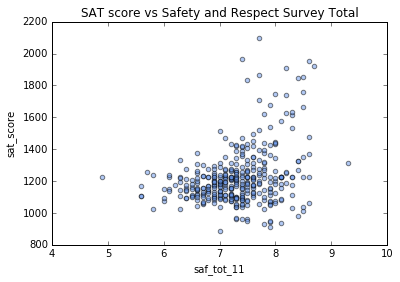

In [85]:
ax5 = combined.plot.scatter(x="saf_tot_11", y="sat_score", color="cornflowerblue", alpha = 0.5, title="SAT score vs Safety and Respect Survey Total")
plt.show()

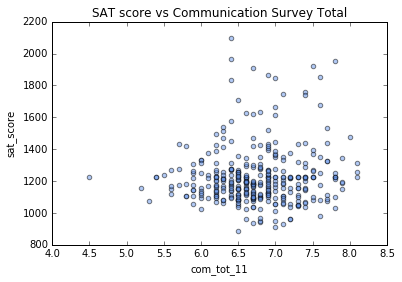

In [86]:
ax5 = combined.plot.scatter(x="com_tot_11", y="sat_score", color="cornflowerblue", alpha = 0.5, title="SAT score vs Communication Survey Total")
plt.show()

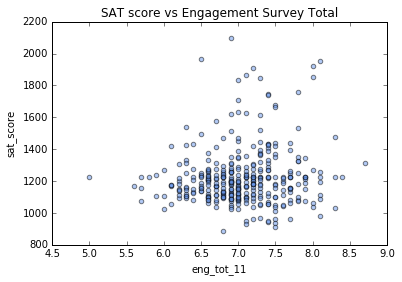

In [87]:
ax5 = combined.plot.scatter(x="eng_tot_11", y="sat_score", color="cornflowerblue", alpha = 0.5, title="SAT score vs Engagement Survey Total")
plt.show()

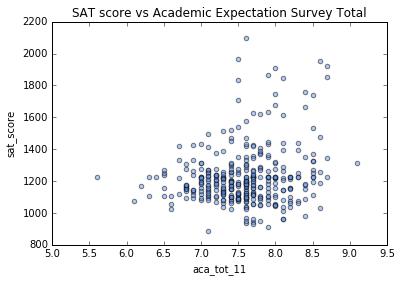

In [88]:
ax5 = combined.plot.scatter(x="aca_tot_11", y="sat_score", color="cornflowerblue", alpha = 0.5, title="SAT score vs Academic Expectation Survey Total")
plt.show()

The strongest correlation is safety score with SAT. 

There is a weak positive correlation with the Academic Expectations survey and the actual SAT performance

# Conclusion

The highest performing schools tend to be:
- High percentage white, asian (or both).
- Highest perceived safety and to some degree academic expectations
- A high percentage of native english speakers

What is not an indication of high performing schools alone?
- Percentage of students taking AP exams.
- Engagement or Communication survey scores.
- Percentage of female (or male) students.
- Class size